In [33]:
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Add
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.regularizers import l1

import os

In [34]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)  # Convert pixel values to numpy array
    img = img.reshape(48, 48)
    image = np.stack((img, img, img), axis=-1)  # Stack the grayscale image to form a 3-channel image
    return image, emotion

In [35]:
#Axes to compare number of emotions per dataset
def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

In [36]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape:", data_X.shape, dataName, "_Y shape:", data_Y.shape)
    return data_X, data_Y

In [37]:
def plot_training(results):
    fig, axes = plt.subplots(1,2, figsize=(18, 6))
    # Plot training & validation accuracy values
    axes[0].plot(results.history['acc'])
    axes[0].plot(results.history['val_acc'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axes[1].plot(results.history['loss'])
    axes[1].plot(results.history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [38]:
##Functions

#Plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [39]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

# early stopping
es = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True)

In [40]:
data = pd.read_csv('../Dataset/Dataset/FER2013/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [41]:
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [42]:
data['emotion'] = data['emotion'].rank(method='dense').astype(int) - 1

In [43]:
emotion_map = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6:'Surprise'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Neutral,6077
3,Surprise,6198
4,Happy,8989
5,Sad,4002
6,Disgust,547


In [44]:
data.shape

(35887, 3)

In [45]:
distinct_values = data['emotion'].unique()
distinct_values

array([0, 2, 4, 6, 3, 5, 1])

In [46]:
df = pd.read_csv('../Dataset/Dataset/CK+/ckextended.csv')
df.shape

(920, 3)

In [47]:
emotion_map = {0: 'Angry', 1:'Digust',2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral ', 7: 'Contempt'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Neutral,593
1,Happy,69
2,Contempt,18
3,Angry,45
4,Digust,59
5,Sad,28
6,Fear,25
7,Surprise,83


In [48]:
emotion_map = {0: 'Angry', 1:'Digust',2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral ', 7: 'Contempt'}
emotion_mapping = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

df = df[df['emotion'] != 7]
df['emotion'] = df['emotion'].map(emotion_mapping)
df['emotion'] = df['emotion'].fillna(np.nan)

df = df.reset_index(drop=True)

In [49]:
distinct_values = df['emotion'].unique()
distinct_values

array([6, 3, 0, 1, 4, 2, 5], dtype=int64)

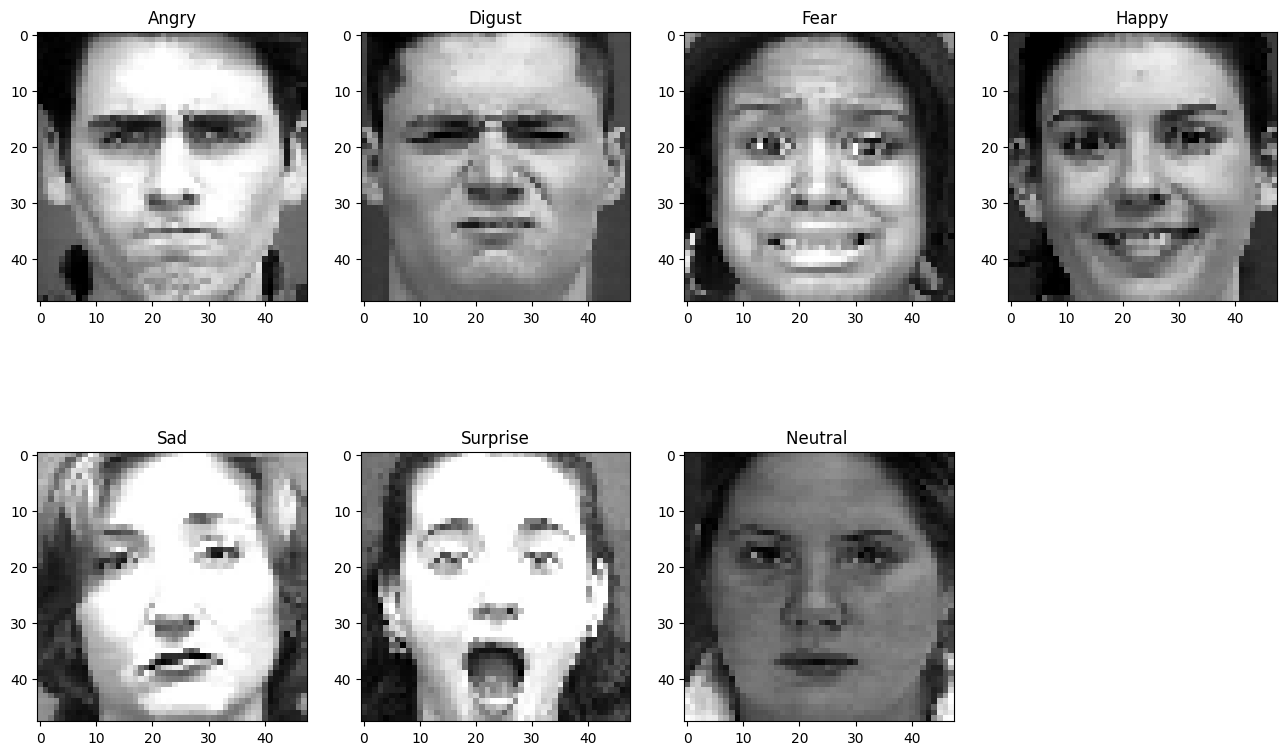

In [50]:
plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = df[df['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

In [51]:
data_train = data[data['Usage']=='Training'].copy()
data_train = pd.concat([data_train, df], ignore_index=True)
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (29611, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [52]:
data_train.emotion.value_counts()

emotion
3    7284
6    5558
4    4858
2    4122
0    4040
5    3254
1     495
Name: count, dtype: int64

In [53]:
data_train = data_train[~data_train['emotion'].isin([1, 2, 5])] 
data_val = data_val[~data_val['emotion'].isin([1, 2, 5])] 
data_test = data_test[~data_test['emotion'].isin([1, 2, 5])] 

emotion_map = {0: 'Angry', 3: 'Happy', 4: 'Sad', 6: 'Neutral'}

emotion_mapping = {0: 0, 3: 1, 4: 2, 6: 3}

data_train['emotion'] = data_train['emotion'].map(emotion_mapping)
data_val['emotion'] = data_val['emotion'].map(emotion_mapping)
data_test['emotion'] = data_test['emotion'].map(emotion_mapping)

# print(data_train['emotion'].unique())  


In [54]:
def row3image(row, emotion_map):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split(), dtype=np.uint8)  # Convert pixel values to numpy array
    img = img.reshape(48, 48)
    image = np.stack((img, img, img), axis=-1)  # Stack the grayscale image to form a 3-channel image
    return image, emotion

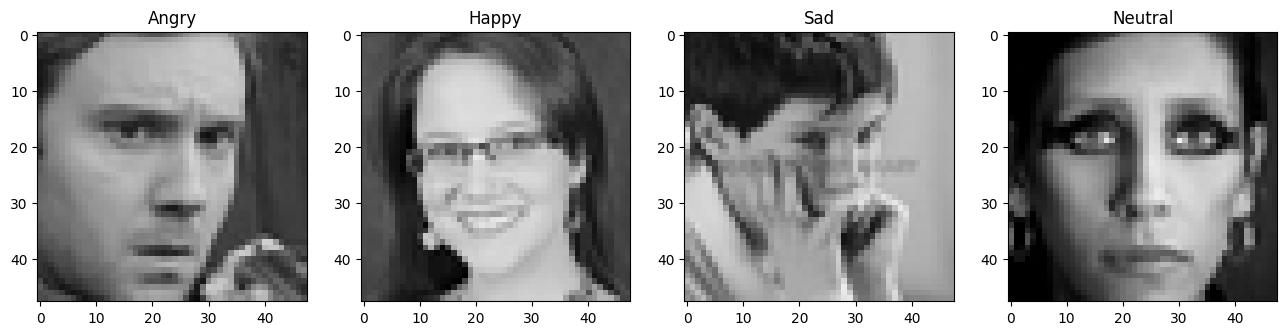

In [55]:
emotion_map = {0: 'Angry',  1: 'Happy', 2: 'Sad', 3: 'Neutral'}

plt.figure(0, figsize=(16,10))
for i in range(4):  # Adjust range to match emotion indices
    face = data_train[data_train['emotion'] == i].iloc[0]  # Use i directly without subtracting 1
    img = row3image(face, emotion_map)
    plt.subplot(2, 4, i+1)  # Increment i by 1 to start subplot index from 1
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

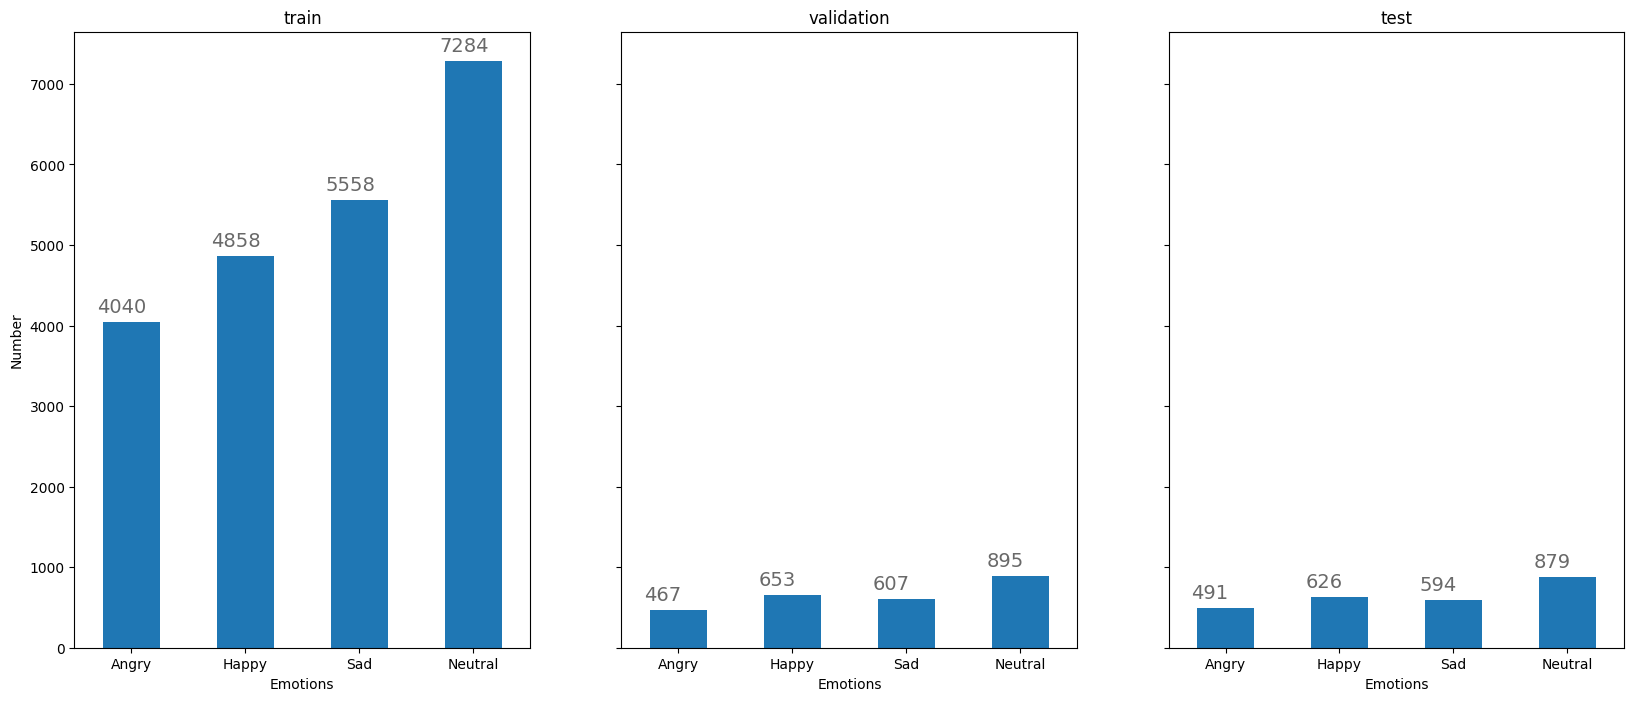

In [56]:
emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral']

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [57]:
num_classes = 4
width, height = 48, 48
num_epochs = 100
batch_size = 32

train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: (21740, 48, 48, 1) train _Y shape: (21740, 4)
val _X shape: (2622, 48, 48, 1) val _Y shape: (2622, 4)
test _X shape: (2590, 48, 48, 1) test _Y shape: (2590, 4)


In [81]:
def build_grid_model(conv_1_filters, conv_2_filters, conv_3_filters, conv_4_filters,
                     conv_1_kernel, conv_2_kernel, conv_3_kernel, conv_4_kernel,
                     dropout_1, dropout_2, dropout_3, dense_units, l1_reg, optimizer, learning_rate):
    model = Sequential()

    # Module 1
    model.add(Conv2D(conv_1_filters, kernel_size=(conv_1_kernel, conv_1_kernel), input_shape=(48, 48, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(conv_1_filters, kernel_size=(conv_1_kernel, conv_1_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(dropout_1))

    # Module 2
    model.add(Conv2D(conv_2_filters, kernel_size=(conv_2_kernel, conv_2_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(conv_2_filters, kernel_size=(conv_2_kernel, conv_2_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Module 3
    model.add(Conv2D(conv_3_filters, kernel_size=(conv_3_kernel, conv_3_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(conv_3_filters, kernel_size=(conv_3_kernel, conv_3_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(conv_4_filters, kernel_size=(conv_4_kernel, conv_4_kernel), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(dropout_2))

    # Flatten
    model.add(Flatten())

    # Dense layers
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(Dropout(dropout_3))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(4, activation='softmax'))  # Assuming 7 classes for the emotions

    # Choose the optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
    else:
        opt = optimizer  # You can add more conditions for other optimizers

    # Compile the model
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [85]:
import itertools

param_grid = {
    'conv_1_filters': [32, 64],
    'conv_2_filters': [64, 96, 128],
    'conv_3_filters': [128, 192, 224],
    'conv_4_filters': [128, 160, 224, 256],
    'conv_1_kernel': [3, 6, 8],
    'conv_2_kernel': [3, 5, 8],
    'conv_3_kernel': [3, 5, 8],
    'conv_4_kernel': [3, 5, 8],
    'dropout_1': [0.1, 0.2, 0.4],
    'dropout_2': [0.0, 0.2, 0.3],
    'dropout_3': [0.0, 0.2, 0.3, 0.4],
    'dense_units': [512, 768, 1024],
    'l1_reg': [0.01, 0.001, 0.0001],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [1e-2, 1e-3, 1e-4], 
    'epochs': [10, 50, 100]
}

def evaluate_model(params):
    fit_params = {k: params.pop(k) for k in ['epochs']}
    
    model = build_grid_model(**params)
    model.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                **fit_params,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))
    score = model.evaluate(val_X, val_Y, verbose=0)
    return score[1]

best_score = 0
best_params = None

for combo in itertools.product(*(param_grid[key] for key in param_grid)):
    params = dict(zip(param_grid.keys(), combo))
    accuracy = evaluate_model(params)
    print(f"{combo} done")
    if accuracy > best_score:
        best_score = accuracy
        best_params = params
        print("Best Score:", best_score)
        print("Best Params:", best_params)

Epoch 1/10
679/679 - 212s - loss: 38.3319 - accuracy: 0.3213 - val_loss: 29.4580 - val_accuracy: 0.3413 - 212s/epoch - 312ms/step
Epoch 2/10
679/679 - 235s - loss: 28.9317 - accuracy: 0.3346 - val_loss: 28.6676 - val_accuracy: 0.3413 - 235s/epoch - 345ms/step
Epoch 3/10
679/679 - 254s - loss: 28.6703 - accuracy: 0.3351 - val_loss: 28.6838 - val_accuracy: 0.3413 - 254s/epoch - 373ms/step
Epoch 4/10
679/679 - 240s - loss: 28.7074 - accuracy: 0.3351 - val_loss: 28.6800 - val_accuracy: 0.3413 - 240s/epoch - 354ms/step
Epoch 5/10
679/679 - 239s - loss: 28.7253 - accuracy: 0.3351 - val_loss: 28.7779 - val_accuracy: 0.3413 - 239s/epoch - 352ms/step
Epoch 6/10
679/679 - 233s - loss: 28.7220 - accuracy: 0.3351 - val_loss: 28.6997 - val_accuracy: 0.3413 - 233s/epoch - 343ms/step
(32, 64, 128, 128, 3, 3, 3, 3, 0.1, 0.0, 0.0, 512, 0.01, 'adam', 0.01, 10) done
Best Score: 0.3413424789905548
Best Params: {'conv_1_filters': 32, 'conv_2_filters': 64, 'conv_3_filters': 128, 'conv_4_filters': 128, 'conv

In [67]:
#VGG-16 Model
model_1 = Sequential()

# Module 1
model_1.add(Conv2D(64, kernel_size=(3, 3), input_shape=(width, height, 1), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 2
model_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Module 3
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Flatten
model_1.add(Flatten())

# Dense layers
model_1.add(Dense(4096))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(4096))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dense(num_classes, activation='softmax'))

model_1.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_11 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)       

In [68]:
history_1 = model_1.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/100
679/679 - 518s - loss: 1.5970 - accuracy: 0.3525 - val_loss: 1.2544 - val_accuracy: 0.4348 - 518s/epoch - 762ms/step
Epoch 2/100
679/679 - 504s - loss: 1.3268 - accuracy: 0.4644 - val_loss: 1.0513 - val_accuracy: 0.5378 - 504s/epoch - 741ms/step
Epoch 3/100
679/679 - 504s - loss: 1.1857 - accuracy: 0.5362 - val_loss: 1.0763 - val_accuracy: 0.5393 - 504s/epoch - 742ms/step
Epoch 4/100
679/679 - 506s - loss: 1.0654 - accuracy: 0.5841 - val_loss: 1.1837 - val_accuracy: 0.5545 - 506s/epoch - 745ms/step
Epoch 5/100
679/679 - 506s - loss: 0.9310 - accuracy: 0.6276 - val_loss: 0.9779 - val_accuracy: 0.6129 - 506s/epoch - 745ms/step
Epoch 6/100
679/679 - 503s - loss: 0.8544 - accuracy: 0.6538 - val_loss: 1.0410 - val_accuracy: 0.5721 - 503s/epoch - 740ms/step
Epoch 7/100
679/679 - 503s - loss: 0.8261 - accuracy: 0.6645 - val_loss: 0.9439 - val_accuracy: 0.6266 - 503s/epoch - 741ms/step
Epoch 8/100
679/679 - 505s - loss: 0.7976 - accuracy: 0.6812 - val_loss: 0.8561 - val_accuracy: 0

In [87]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_1.predict(test_X), axis=1)
vgg_16_score = accuracy_score(test_true, test_pred)
print("Model 1 Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

81/81 [==============================] - 32s 388ms/step
Model 1 Accuracy on test set: 0.7432


In [78]:
report = classification_report(test_true, test_pred, target_names=['Angry', 'Happy', 'Sad', 'Neutral'])
print(report)

              precision    recall  f1-score   support

       Angry       0.73      0.62      0.67       491
       Happy       0.91      0.91      0.91       879
         Sad       0.70      0.52      0.60       594
     Neutral       0.60      0.82      0.69       626

    accuracy                           0.74      2590
   macro avg       0.74      0.72      0.72      2590
weighted avg       0.75      0.74      0.74      2590



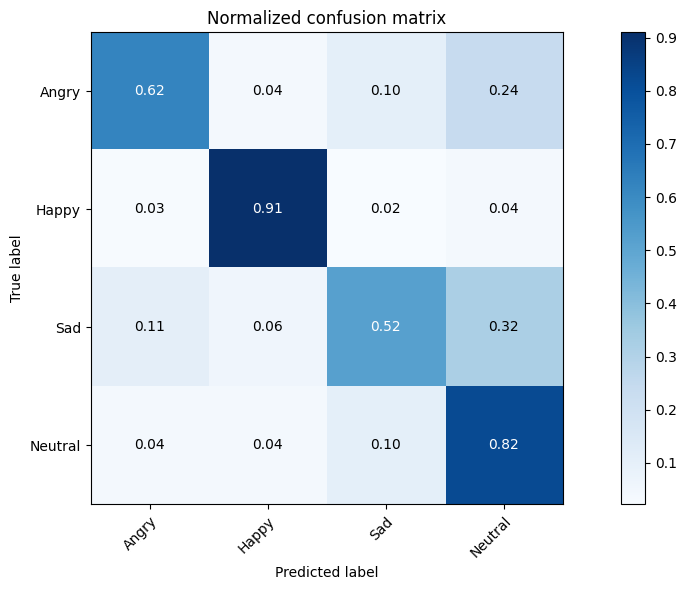

In [79]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

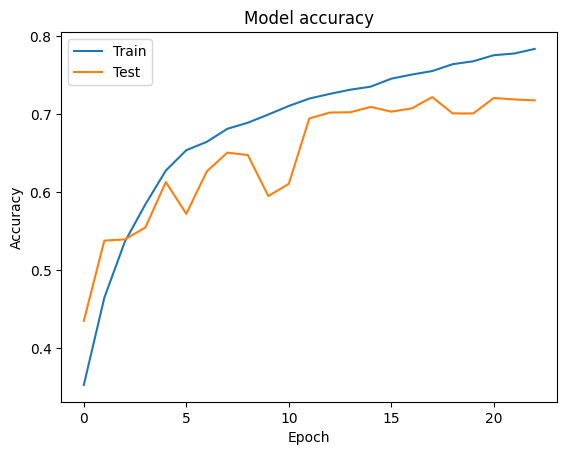

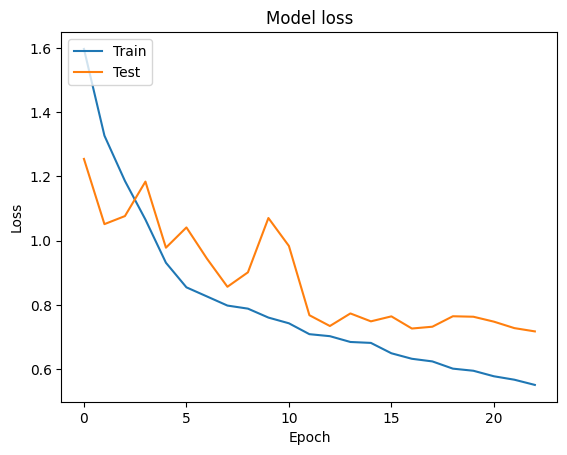

In [80]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [86]:
model_1.save('MODEL1.keras')

In [65]:
model_3 = Sequential()

# Initial Convolutional layer
model_3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(width, height, 1)))
model_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(2, 2))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(1024, activation='relu'))
model_3.add(Dropout(0.5))
    
model_3.add(Dense(num_classes, activation='softmax'))

model_3.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Display model summary
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 128)      

In [66]:
history_3 = model_3.fit(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=100,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))

Epoch 1/100
679/679 - 344s - loss: 3.8378 - accuracy: 0.3615 - val_loss: 3.3772 - val_accuracy: 0.4485 - 344s/epoch - 507ms/step
Epoch 2/100
679/679 - 340s - loss: 2.9991 - accuracy: 0.4107 - val_loss: 2.6362 - val_accuracy: 0.4722 - 340s/epoch - 500ms/step
Epoch 3/100
679/679 - 366s - loss: 2.4291 - accuracy: 0.4485 - val_loss: 2.0773 - val_accuracy: 0.5214 - 366s/epoch - 539ms/step
Epoch 4/100
679/679 - 362s - loss: 1.9734 - accuracy: 0.4859 - val_loss: 1.7403 - val_accuracy: 0.5275 - 362s/epoch - 533ms/step
Epoch 5/100
679/679 - 341s - loss: 1.6520 - accuracy: 0.5224 - val_loss: 1.4929 - val_accuracy: 0.5420 - 341s/epoch - 502ms/step
Epoch 6/100
679/679 - 350s - loss: 1.4246 - accuracy: 0.5529 - val_loss: 1.3203 - val_accuracy: 0.5736 - 350s/epoch - 515ms/step
Epoch 7/100
679/679 - 330s - loss: 1.2591 - accuracy: 0.5772 - val_loss: 1.3157 - val_accuracy: 0.5454 - 330s/epoch - 485ms/step
Epoch 8/100
679/679 - 296s - loss: 1.1490 - accuracy: 0.6007 - val_loss: 1.1044 - val_accuracy: 0

In [88]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model_3.predict(test_X), axis=1)
improved_vgg_16_score = accuracy_score(test_true, test_pred)
print("Model 1 Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

81/81 [==============================] - 16s 191ms/step
Model 1 Accuracy on test set: 0.7135


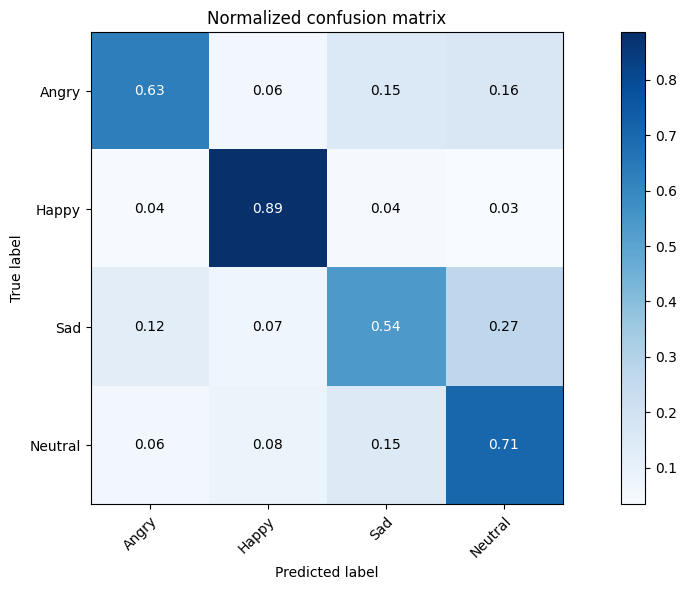

In [82]:
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [83]:
report = classification_report(test_true, test_pred, target_names=['Angry', 'Happy', 'Sad', 'Neutral'])
print(report)

              precision    recall  f1-score   support

       Angry       0.68      0.63      0.65       491
       Happy       0.86      0.89      0.87       879
         Sad       0.61      0.54      0.57       594
     Neutral       0.62      0.71      0.66       626

    accuracy                           0.71      2590
   macro avg       0.69      0.69      0.69      2590
weighted avg       0.71      0.71      0.71      2590



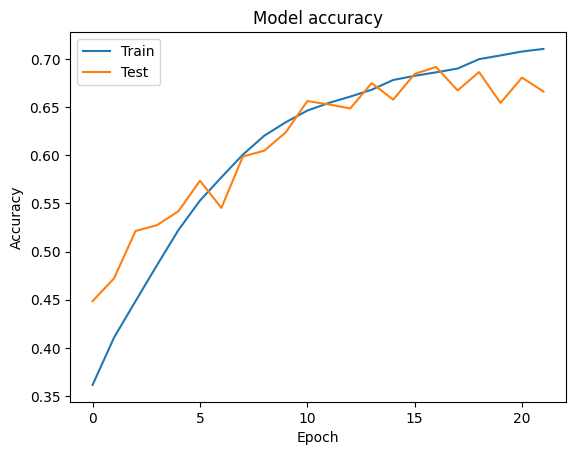

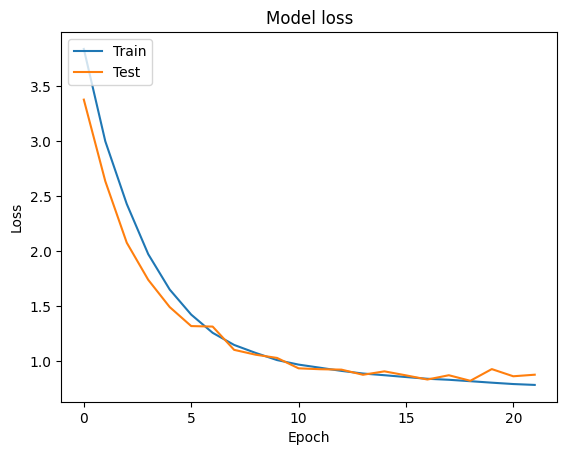

In [84]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [85]:
model_3.save('MODEL3.keras')